# Voice Assistant

## Wake word detection

In [1]:
from transformers import pipeline
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2", device=device
)

In [2]:
classifier.model.config.id2label

{0: 'backward',
 1: 'follow',
 2: 'five',
 3: 'bed',
 4: 'zero',
 5: 'on',
 6: 'learn',
 7: 'two',
 8: 'house',
 9: 'tree',
 10: 'dog',
 11: 'stop',
 12: 'seven',
 13: 'eight',
 14: 'down',
 15: 'six',
 16: 'forward',
 17: 'cat',
 18: 'right',
 19: 'visual',
 20: 'four',
 21: 'wow',
 22: 'no',
 23: 'nine',
 24: 'off',
 25: 'three',
 26: 'left',
 27: 'marvin',
 28: 'yes',
 29: 'up',
 30: 'sheila',
 31: 'happy',
 32: 'bird',
 33: 'go',
 34: 'one'}

In [3]:
from transformers.pipelines.audio_utils import ffmpeg_microphone_live


def launch_fn(
    wake_word="marvin",
    prob_threshold=0.5,
    chunk_length_s=2.0,
    stream_chunk_s=0.25,
    debug=False,
):
    if wake_word not in classifier.model.config.label2id.keys():
        raise ValueError(
            f"Wake word {wake_word} not in set of valid class labels, pick a wake word in the set {classifier.model.config.label2id.keys()}."
        )

    sampling_rate = classifier.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Listening for wake word...")
    for prediction in classifier(mic):
        prediction = prediction[0]
        if debug:
            print(prediction)
        if prediction["label"] == wake_word:
            if prediction["score"] > prob_threshold:
                return True

In [18]:
launch_fn(debug=True)

Listening for wake word...


## Speech transcription

In [5]:
transcriber = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base.en", device=device
)

In [6]:
import sys


def transcribe(chunk_length_s=5.0, stream_chunk_s=1.0):
    sampling_rate = transcriber.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Start speaking...")
    for item in transcriber(mic, generate_kwargs={"max_new_tokens": 128}):
        sys.stdout.write("\033[K")
        print(item["text"], end="\r")
        if not item["partial"][0]:
            break

    return item["text"]

In [7]:
transcribe()

Start speaking...


UnboundLocalError: local variable 'item' referenced before assignment

## Language model query

In [8]:
from huggingface_hub import HfFolder
import requests


def query(text, model_id="tiiuae/falcon-7b-instruct"):
    api_url = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {HfFolder().get_token()}"}
    payload = {"inputs": text}

    print(f"Querying...: {text}")
    response = requests.post(api_url, headers=headers, json=payload)
    return response.json()[0]["generated_text"][len(text) + 1 :]

In [9]:
query("What does Hugging Face do?")

Querying...: What does Hugging Face do?


'Hugging Face is a company that provides natural language processing and machine learning tools for developers. They'

## Synthesise speech

In [10]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

In [11]:
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Found cached dataset cmu-arctic-xvectors (/home/ubuntu/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f)


In [12]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

In [13]:
from IPython.display import Audio

audio = synthesise(
    "Hugging Face is a company that provides natural language processing and machine learning tools for developers."
)

Audio(audio, rate=16000)

## Marvin 🤖

In [ ]:
launch_fn()
transcription = transcribe()
response = query(transcription)
audio = synthesise(response)

Audio(audio, rate=16000, autoplay=True)

## Generalise to anything 🪄

In [16]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.0 MB/s eta 0:00:00m eta 0:00:01


In [14]:
from transformers import HfAgent

agent = HfAgent(
    url_endpoint="https://api-inference.huggingface.co/models/bigcode/starcoder"
)

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image of a cat.


==Code generated by the agent==
image = image_generator(prompt="cat")


==Result==


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

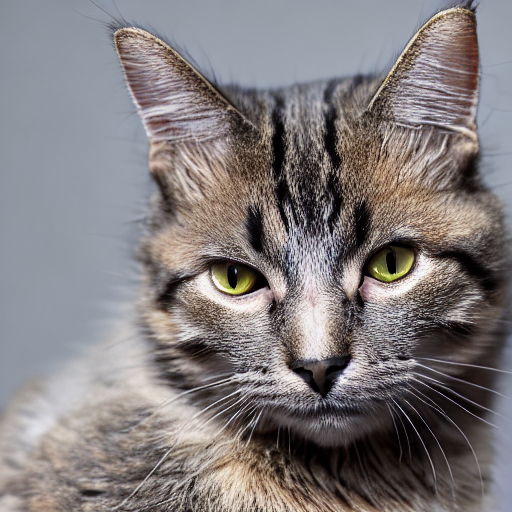

In [17]:
agent.run("Generate an image of a cat")

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image.


==Code generated by the agent==
image = image_generator(prompt="beautiful woman with a sword")


==Result==


  0%|          | 0/25 [00:00<?, ?it/s]

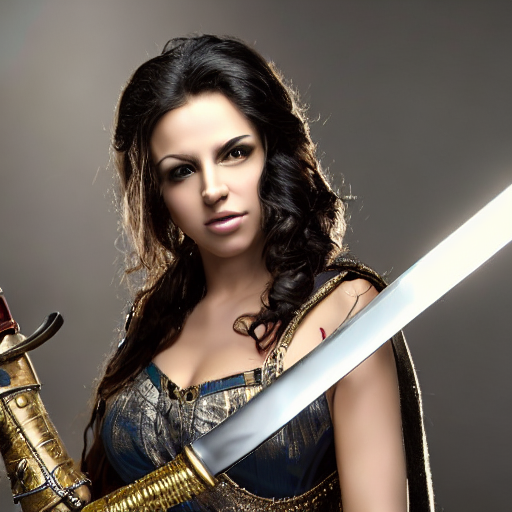

In [23]:
agent.run("generate an image of 'beautiful woman with a sword' ")

In [ ]:
launch_fn()
transcription = transcribe()
agent.run(transcription)